In [3]:
import classification
import numpy as np
import os
import sys
import pandas as pd
import warnings
import scipy.io
warnings.filterwarnings("ignore")
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
#using less conservative fc matrices
dataDir = thisDir + 'data/mvpa_data/'
framesDir = thisDir + 'data/mvpa_data/tmask_frames_ran/'
outDir = thisDir + 'output/mLmin/results/ridge/frames_ran/'

#frameList=[5,10,15,20,25,30,40,50,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350]
framesList=[5,25,50,100,150,200,250,300,350]
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
#acc and days per sub for each analysis at 350 frames
#acc and days per sub for each analysis at 150 frames

def matFiles(df='path'):
    """
    Convert matlab files into upper triangle np.arrays
    Parameters
    -----------
    df : str
        Path to file
    Returns
    -----------
    ds : 2D upper triangle FC measures in (roi, days) format

    """
    #Consistent parameters to use for editing datasets
    nrois=333
    #Load FC file
    fileFC=scipy.io.loadmat(df)

    
    #Convert to numpy array
    fileFC=np.array(fileFC['parcel_corrmat'])
    #Replace nans and infs with zero
    fileFC=np.nan_to_num(fileFC)
    #if you dont have enough sessions return an empty np array 
    if fileFC.ndim<3:
        return np.empty([])
    else:
        nsess=fileFC.shape[2]
    #Index upper triangle of matrix
        mask=np.triu_indices(nrois,1)
        ds=np.empty((nsess, int(nrois*(nrois-1)/2)))
        count=0
    #Loop through all 10 days to reshape correlations into linear form
        for sess in range(nsess):
            tmp=fileFC[:,:,sess]
            ds[count]=tmp[mask]
            count=count+1
        return ds


In [5]:
subs=[]
mem=[]
rest=[]
frame=[]
total_days=[]
for f in framesList:
    for sub in subList:
        FC=matFiles(framesDir+'mem/'+str(f)+'/'+sub+'_parcel_corrmat.mat')
        restFC=matFiles(framesDir+'rest/'+str(f)+'/'+sub+'_parcel_corrmat.mat')
        if FC.size==1:
            size=0
        else:
        #how many days
            size=FC.shape[0]
        if restFC.size==1:
            rest_size=0
        else:
            rest_size=restFC.shape[0]
        days=size+rest_size
        total_days.append(days)
        frame.append(f)
        subs.append(sub)
        mem.append(size)
        rest.append(rest_size)
df=pd.DataFrame({'train_sub':subs,'mem':mem,'rest':rest,'frames':frame,'days':total_days})

In [42]:
DS_mem=pd.read_csv(thisDir+'output/mL/results/ridge/permutation/DS/resampleFrames.csv',na_values=[9999])
CV_mem=pd.read_csv(thisDir+'output/mL/results/ridge/permutation/CV/resampleFrames.csv',na_values=[9999])
CV_mem=CV_mem[(CV_mem['train_task']=='mem')]

CV=CV_mem.merge(df,how='left',on=['train_sub','frames'])
DS=DS_mem.merge(df,how='left',on=['train_sub','frames'])

CV['framesXdays']=CV['frames']*CV['days']
DS['framesXdays']=DS['frames']*DS['days']


CV.rename(columns={'train_sub':'Subjects'},inplace=True)
DS.rename(columns={'train_sub':'Subjects'},inplace=True)

In [44]:
df

,Subjects,test_sub,acc,frames,mem,rest,days,framesXdays
0,MSC01,MSC02,0.500,5,10,10,20,100
1,MSC01,MSC03,0.585,5,10,10,20,100
2,MSC01,MSC04,0.570,5,10,10,20,100
3,MSC01,MSC05,0.535,5,10,10,20,100
4,MSC01,MSC06,0.500,5,10,10,20,100
...,...,...,...,...,...,...,...,...
10075,MSC10,MSC03,NaN,350,0,8,8,2800
10076,MSC10,MSC04,NaN,350,0,8,8,2800
10077,MSC10,MSC05,NaN,350,0,8,8,2800
10078,MSC10,MSC06,NaN,350,0,8,8,2800


In [5]:
fCV=pd.read_csv(outDir+'CV/allFrames.csv',na_values=[9999])
fSS=pd.read_csv(outDir+'SS/allFrames.csv',na_values=[9999])
fDS=pd.read_csv(outDir+'DS/allFrames.csv',na_values=[9999])
fBS=pd.read_csv(outDir+'BS/allFrames.csv',na_values=[9999])

CV= fCV.merge(df,how='left',on=['train','frames'])
SS= fSS.merge(df,how='left',on=['train','frames'])
DS= fDS.merge(df,how='left',on=['train','frames'])
BS= fBS.merge(df,how='left',on=['train','frames'])

SS['framesXdays']=SS['frames']*SS['days']
CV['framesXdays']=CV['frames']*CV['days']
DS['framesXdays']=DS['frames']*DS['days']
BS['framesXdays']=BS['frames']*BS['days']

,acc,train,frames,mem,rest,days,framesXdays
0,0.875000,MSC01,5,10,10,20,100
1,0.425000,MSC02,5,10,10,20,100
2,0.393750,MSC03,5,8,10,18,90
3,0.745000,MSC04,5,10,10,20,100
4,0.525000,MSC05,5,10,10,20,100
...,...,...,...,...,...,...,...
179,0.625000,MSC04,350,2,9,11,3850
180,0.760000,MSC05,350,5,10,15,5250
181,0.791667,MSC06,350,6,10,16,5600
182,0.687500,MSC07,350,4,10,14,4900


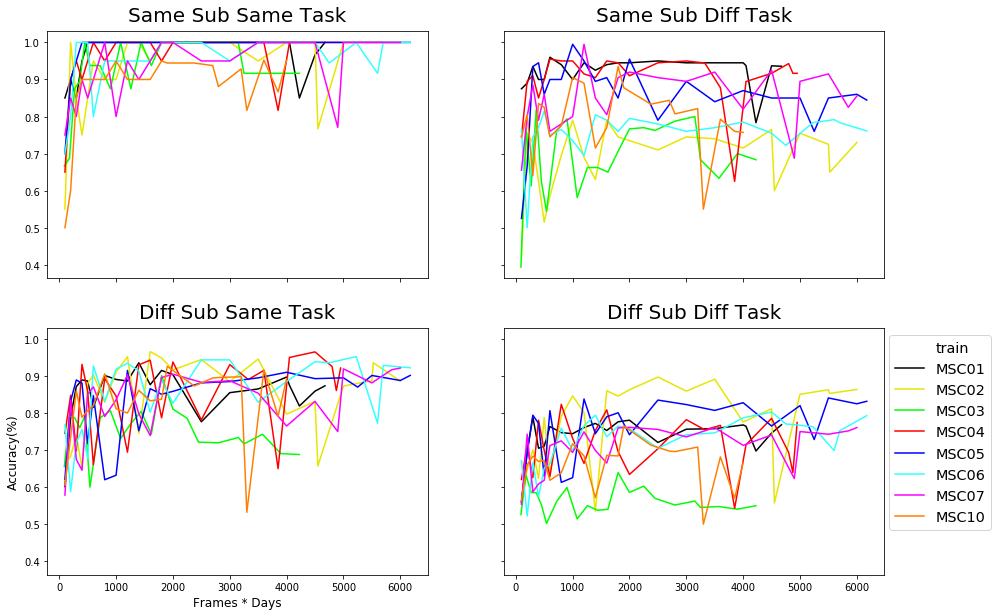

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
%matplotlib inline
MSCList=['1','2','3','4','5','6','7','10']
MSC_colors=np.array([[0, 0, 0],[0.9, 0.9, 0],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0.2, 1, 1],[1, 0, 1],[1, 0.5, 0]])
MSCdict=dict(zip(MSCList, [mcolors.to_rgba(m) for m in MSC_colors]))
mcolors.get_named_colors_mapping().update(MSCdict)

#Create figure space
fig=plt.figure(figsize=(15,10), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 1 rows by 3 columns
gs = gridspec.GridSpec(nrows=2, ncols=2)
ax1=fig.add_subplot(gs[0,0])
plt.setp(ax1.get_xticklabels(), visible=False)
ax=sns.lineplot(x='framesXdays',y='acc',hue='train',ci=None,data=CV,ax=ax1,legend=False,color='r', palette=['1','2','3','4','5','6','7','10'])
ax.set_title('Same Sub Same Task', fontsize=20, pad=10)
plt.xlabel('')
plt.ylabel("")

ax2=fig.add_subplot(gs[0,1],sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax=sns.lineplot(x='framesXdays',y='acc',hue='train',ci=None,data=SS,ax=ax2,legend=False,color='r', palette=['1','2','3','4','5','6','7','10'])
ax.set_title('Same Sub Diff Task', fontsize=20, pad=10)
plt.xlabel('')
plt.ylabel("")

ax3=fig.add_subplot(gs[1,0],sharex=ax1,sharey=ax1)
ax=sns.lineplot(x='framesXdays',y='acc',hue='train',ci=None,data=DS,ax=ax3,legend=False,color='r', palette=['1','2','3','4','5','6','7','10'])
ax.set_title('Diff Sub Same Task', fontsize=20, pad=10)
plt.xlabel('Frames * Days',fontsize=12)
plt.ylabel("Accuracy(%)",fontsize=12)




ax4=fig.add_subplot(gs[1,1],sharex=ax2,sharey=ax3)
plt.setp(ax4.get_yticklabels(), visible=False)
ax=sns.lineplot(x='framesXdays',y='acc',hue='train',ci=None,data=BS,ax=ax4,color='r', palette=['1','2','3','4','5','6','7','10'])
ax.set_title('Diff Sub Diff Task', fontsize=20, pad=10)
plt.xlabel('')
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.3, 1.0),loc='upper right',fontsize='x-large')

plt.savefig(thisDir+'output/mL/images/ridge/figs/line_frameDays_plots_ran.png', bbox_inches='tight')


Text(0, 0.5, '')

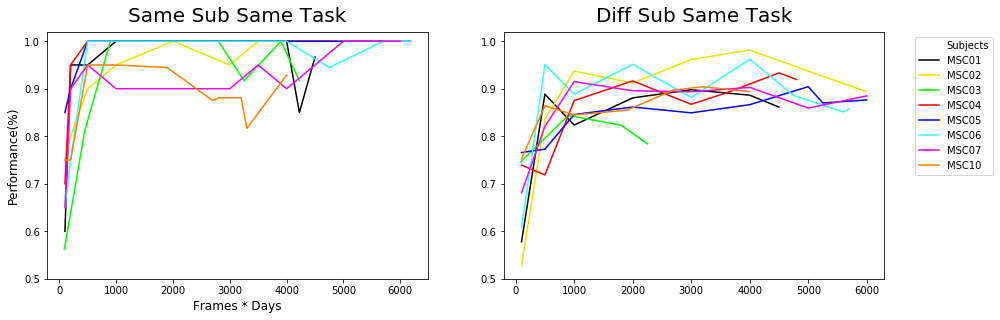

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
%matplotlib inline
MSCList=['1','2','3','4','5','6','7','10']
MSC_colors=np.array([[0, 0, 0],[0.9, 0.9, 0],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0.2, 1, 1],[1, 0, 1],[1, 0.5, 0]])
MSCdict=dict(zip(MSCList, [mcolors.to_rgba(m) for m in MSC_colors]))
mcolors.get_named_colors_mapping().update(MSCdict)

#Create figure space
fig=plt.figure(figsize=(15,10), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 1 rows by 2 columns
gs = gridspec.GridSpec(nrows=2, ncols=2)
ax1=fig.add_subplot(gs[0,0])
ax=sns.lineplot(x='framesXdays',y='acc',hue='Subjects',data=CV,ci=None,ax=ax1,legend=False,color='r', palette=['1','2','3','4','5','6','7','10'])
ax.set_title('Same Sub Same Task', fontsize=20, pad=10)
plt.xlabel('Frames * Days',fontsize=12)
plt.ylabel("Performance(%)",fontsize=12)
ax.set(ylim=(.5, 1.02))
ax2=fig.add_subplot(gs[0,1],sharey=ax1)
ax=sns.lineplot(x='framesXdays',y='acc',hue='Subjects',data=DS,ci=None,ax=ax2,color='r', palette=['1','2','3','4','5','6','7','10'])
ax.set_title('Diff Sub Same Task', fontsize=20, pad=10)
plt.legend(bbox_to_anchor=(1.3, 1.0),loc='upper right')
plt.xlabel('')
plt.ylabel("")

#plt.savefig(thisDir+'output/mL/images/ridge/figs/line_framePERM_plots.png', bbox_inches='tight')


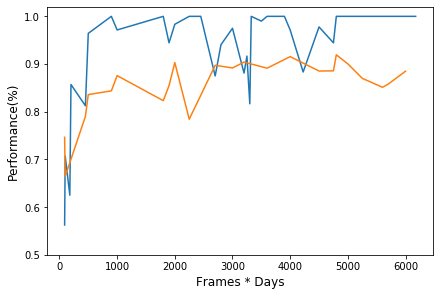

In [48]:
#Create figure space
#Add grid space for subplots 1 rows by 2 columns
ax=sns.lineplot(x='framesXdays',y='acc',data=CV,ci=None)
sns.lineplot(x='framesXdays',y='acc',data=DS,ci=None,ax=ax)
plt.xlabel('Frames * Days',fontsize=12)
plt.ylabel("Performance(%)",fontsize=12)
ax.set(ylim=(.5, 1.02))

plt.savefig(thisDir+'output/mL/images/ridge/figs/line_framePERM_CVDS.png', bbox_inches='tight')